In [5]:
import numpy as np
from matplotlib import pyplot as plt
from src.FireFramework import * # importieren des Frameworks
from PIL import Image

### Hilfsfunktionen

In [144]:
def drawImage(field, index):
    plt.imshow(np.stack([field[index,:,:,1],field[index,:,:,0],np.zeros(shape = (100,100))], axis = 2))
    plt.show()

In [7]:
def loadImage(path, size):
    img_ = Image.open(path).resize(size, Image.BICUBIC)
    img = np.array(img_) / 255
    img_.close()
    return img

### Daten definieren

In [167]:
# Liste der pro Zelle zu speichernden Werte
params = ["fuel", "fire", "windx", "windy", "height"]

# Relativvektoren der zu betrachtenen Nachbarn
relative_neighbours = [(-1,0),(1,0),(0,1),(0,-1),(-1,1),(1,1),(-1,-1),(1,-1)] 

In [168]:
fuelmap = loadImage("data/fuelmap1.jpg", (100,100))
heightmap = loadImage("data/heightmap.jpg", (100,100))

def initial_field(row, col):
    fuel = (1 - fuelmap[row,col,2])**2
    burn = 0
    if row == 20 and col == 20: burn = 1
    
    height = heightmap[row,col,0]
    windx = 1
    windy = 0
    
    return [fuel, burn, windx, windy, height] # Hier der Anfangswert-return

### Modell definieren

In [176]:
def transition(cellState, neighbourStates, returnState):
    #Beispiel
    p_burn = 1/8 * sum([n.getParam("fire") for n in neighbourStates]) #Anteil der brennenden Nachbarzellen
    p_burn *= cellState.getParam("fuel")
    
    p_stop = (1 - cellState.getParam("fuel")) ** 8  #Erlöschen bei wenig Brennwert
    
    if p_burn >= np.random.uniform():
        returnState.addToParam("fire", 0.5*(1 - cellState.getParam("fire")))
        
    if p_stop >= np.random.uniform():
        returnState.addToParam("fire", - 0.5*cellState.getParam("fire"))
        
    returnState.addToParam("fuel", -0.05*cellState.getParam("fire")) # Verringerung des Brennwerts
    if returnState.getParam("fuel") < 0:
        returnState.setParam("fuel", 0)

In [170]:
# Hier wird das Gitter erzeugt und die oben definierten Parameter übergeben..
g = Grid(100, 100, params, relative_neighbours, transition, initial_field)

### Modell auswerten

In [171]:
# Läuft mehrere Iterationen durch und gibt das ganze Feld (mit zeitlicher Entwicklung) zurück.
result = g.runModel(150)

0%
10%
20%
30%
40%
50%
60%
70%
80%
90%


In [134]:
#np.save("output/probabilityasintensity",result)

In [172]:
total_values = np.sum(result, axis = (1,2))

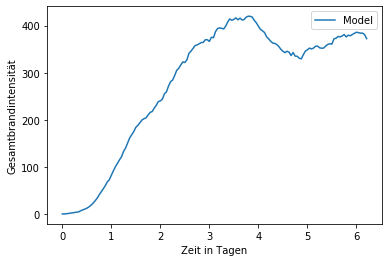

In [173]:
plt.plot(np.arange(150) / 24, total_values[:,1], label = "Model")
plt.xlabel("Zeit in Tagen")
plt.ylabel("Gesamtbrandintensität")
plt.legend()

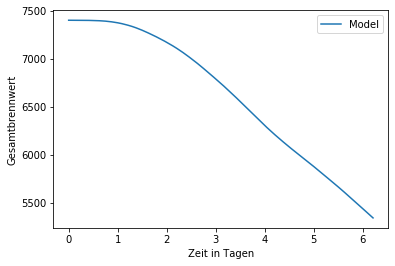

In [174]:
plt.plot(np.arange(150) / 24, total_values[:,0], label = "Model")
plt.xlabel("Zeit in Tagen")
plt.ylabel("Gesamtbrennwert")
plt.legend()

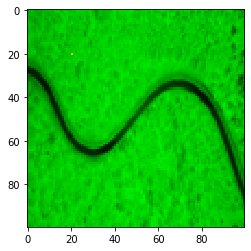

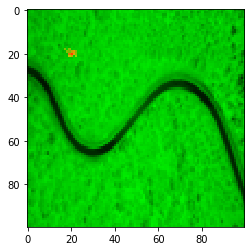

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


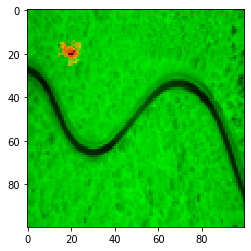

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


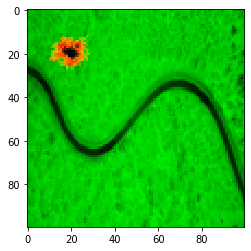

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


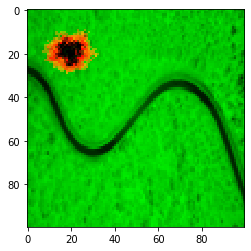

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


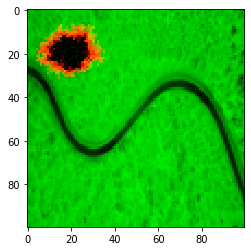

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


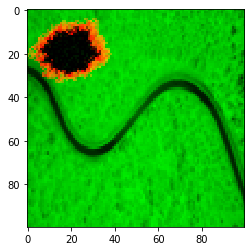

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


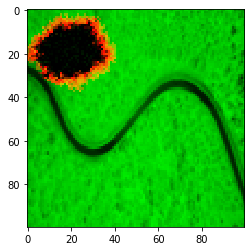

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


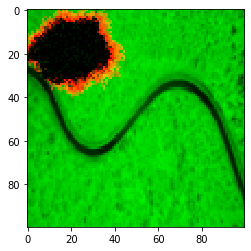

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


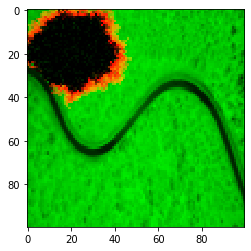

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


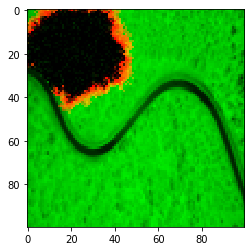

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


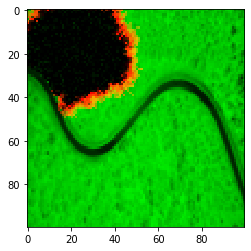

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


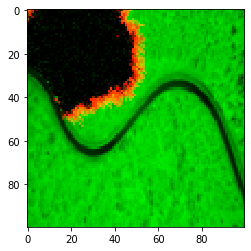

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


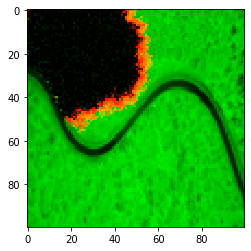

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


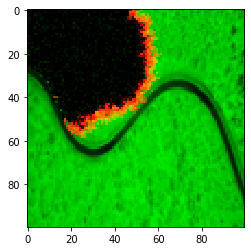

In [175]:
for i in range(15):
    drawImage(result, i * 10)